In [1]:
# !pip3 install -U transformers==4.41.2 torch==2.3.1 timm 
# !pip3 install -U accelerate 

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch
%matplotlib inline  

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import os

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [12]:
DATA_DIR = "./data/input"

In [13]:
IMAGE_PATH = os.path.join(DATA_DIR, "google-sec-1.png")

In [19]:
image = Image.open(IMAGE_PATH).convert("RGB")

In [53]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=4096,
      early_stopping=False,
      do_sample=False,
      num_beams=1,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [54]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

In [55]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[1423.0, 29.0625, 1592.0, 29.0625, 1592.0, 56.34375, 1423.0, 56.34375], [1111.0, 58.71875, 1904.0, 58.71875, 1904.0, 89.5625, 1111.0, 89.5625], [1429.0, 95.5, 1583.0, 95.5, 1583.0, 122.75, 1429.0, 122.75], [1411.0, 152.375, 1619.0, 152.375, 1619.0, 174.875, 1411.0, 174.875], [2009.0, 163.125, 2148.0, 163.125, 2148.0, 185.625, 2009.0, 185.625], [1293.0, 173.75, 1737.0, 173.75, 1737.0, 198.625, 1293.0, 198.625], [1383.0, 195.125, 1644.0, 195.125, 1644.0, 218.875, 1383.0, 218.875], [2048.0, 185.625, 2112.0, 185.625, 2112.0, 205.75, 2048.0, 205.75], [2802.0, 185.625, 2856.0, 185.625, 2856.0, 205.75, 2802.0, 205.75], [2000.0, 205.75, 2164.0, 205.75, 2164.0, 228.25, 2000.0, 228.25], [1296.0, 228.25, 1371.0, 228.25, 1371.0, 249.625, 1296.0, 249.625], [1653.0, 228.25, 1740.0, 228.25, 1740.0, 249.625, 1653.0, 249.625], [2414.0, 228.25, 2512.0, 228.25, 2512.0, 249.625, 2414.0, 249.625], [2756.0, 205.75, 2904.0, 205.75, 2904.0, 228.25, 2756.0, 228.25], [13.60

In [56]:
from PIL import Image, ImageDraw, ImageFont 
import random

In [57]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

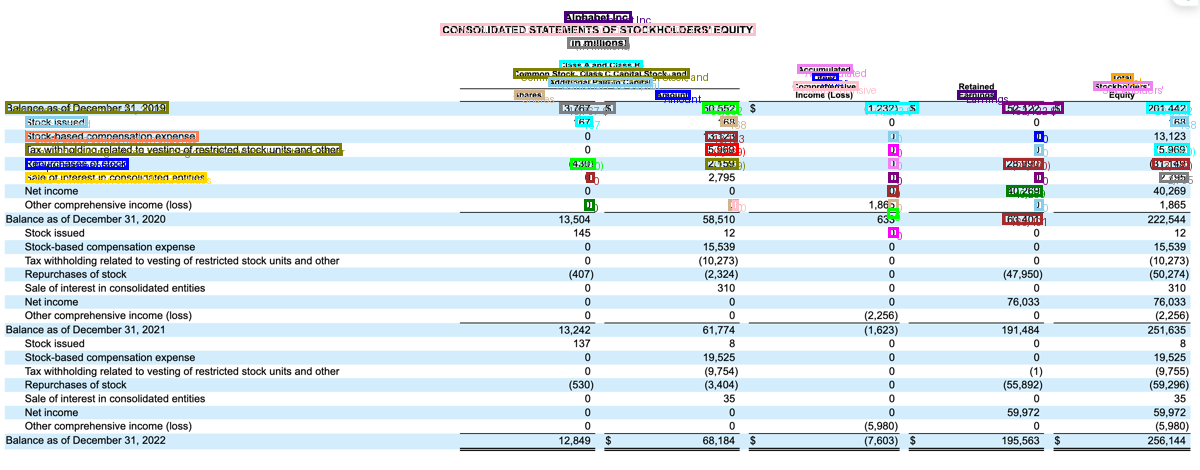

In [58]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 1200 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)  